# Librerias

In [ ]:
import pandas as pd
import numpy as np
import pickle
import time

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import sklearn as sk
from collections import defaultdict
import plotly.graph_objects as go
%matplotlib inline


#Modelado
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV , cross_validate, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn import preprocessing


#KNN
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, BallTree, KDTree

#SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Ensambles
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier 

#Metricas
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, confusion_matrix,classification_report, f1_score
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.pipeline import Pipeline


#Hiperparametros
from sklearn.model_selection import RandomizedSearchCV

#configuración warnings
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Importación del dataset

In [ ]:
url_train_encoded = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-3/checkpoint-3/df_hotels_train_encoded.csv'
url_test_encoded = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-3/checkpoint-3/df_hotels_test_encoded.csv'
url_train = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-3/checkpoint-3/hotels-train.csv'
url_test = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-3/checkpoint-3/hotels-test.csv'
df_train_encoded = pd.read_csv(url_train_encoded)
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_test_encoded = pd.read_csv(url_test_encoded)

In [ ]:
df_hotels_train_encoded = df_train_encoded.copy()
df_hotels_test_encoded = df_test_encoded.copy()
df_hotels_train = df_train.copy()
df_hotels_test = df_test.copy()

In [ ]:
df_hotels_train_encoded.columns

Index(['Unnamed: 0', 'lead_time', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'id', 'is_canceled', 'hotel_Resort Hotel',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'reserved_room_type_B',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L', 'reserved_room_type_P',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       '

In [ ]:
df_hotels_train_encoded.drop(columns=["Unnamed: 0"], inplace=True)
#df_hotels_train_encoded.drop(columns=["Unnamed: 0"], inplace=True)
df_hotels_train.drop(columns=["Unnamed: 0"], inplace=True)
df_hotels_test.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
df_hotels_test_encoded.columns

Index(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'id', 'hotel_Resort Hotel',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'reserved_room_type_B',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L', 'reserved_room_type_P',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type

# Funciones auxiliares


In [ ]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='F1 Score',
    showlegend=False)
    fig.show()

In [ ]:
def show_performance(y_test, y_pred):
  print(f"F1 Score: {f1_score(y_test, y_pred, average='binary')}")
  print(f"Classification Report: \n {classification_report(y_test, y_pred)}")
  matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(matrix, cmap='Greens', annot=True, fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

In [ ]:
def print_search(search, t):
  print(f"Mean scores: {search.cv_results_['mean_test_score']} found in {time.time() - t}")
  print(search.best_params_)
  print(search.best_score_)

In [ ]:
def evaluate_model(model, x, y):
    scorer = make_scorer(sk.metrics.f1_score)
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring=scorer, cv=cv, verbose=3, n_jobs=-1, error_score='raise')
    return scores

In [ ]:
def train_with_cv(model, params, folds, x_train, y_train, jobs=-1):
  # Spits que respeten la proporción de las clases
  kfoldcv = StratifiedKFold(n_splits=folds) 
  
  #Creo Modelo con los mejores hiperparámetros 
  model.set_params(**params)

  #Selecciono métrica F1-Score
  scorer_fn = make_scorer(sk.metrics.f1_score)

  #Hago CV
  resultados = cross_validate(model,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True, n_jobs=jobs, verbose=10)

  metricsCV=resultados['test_score']
  print(f"Best Score: {max(metricsCV)}")
  return resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

# Separación de conjuntos de Test y Train

In [ ]:
x_model = df_hotels_train_encoded
y_model = df_hotels_train['is_canceled']
x_model.drop('id', axis=1, inplace=True)
x_model.drop('is_canceled', axis=1, inplace=True)


#Podemos ver que el numero de filas coincide.
assert(x_model.shape[0] == y_model.shape[0])
print(f"Shape del X: {x_model.shape} y Shape del Y: {y_model.shape}")

Shape del X: (59477, 41) y Shape del Y: (59477,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_model, 
                                                    y_model,
                                                    test_size=0.2,
                                                    random_state=145,
                                                    )

len(x_train) , len(x_test)

(47581, 11896)

### ***Modo de ejecucion***


1.   inject == True (No correra los fits, usara valores pasados.)
2.   inject == False (Corre con todos los fits, no termina nunca je).



In [ ]:
inject = True

# Clasificación con KNN


In [ ]:
#Clasificador KNN
model = KNeighborsClassifier(n_jobs=-1)

In [ ]:
import time

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(50,500), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev'],
              'leaf_size': range(30,200, 10) #maybe not needed.
             }

# Metrica a optimizar (F1 Score)
scorer = make_scorer(sk.metrics.f1_score)

iters = 40
folds = 7

search = RandomizedSearchCV(model, params_grid, cv=folds, scoring = scorer, n_iter=iters, random_state=231, verbose=10, n_jobs=-1)

start = time.time()
if not inject:
  search.fit(X = x_train, y = y_train)
  print_search(search, start)

In [ ]:
#Best Score: 0.79
knn_best_params = search.best_params_ if not inject else {'weights': 'distance', 'n_neighbors': 120, 'metric': 'manhattan', 'leaf_size': 120, 'algorithm': 'brute'}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    9.1s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    9.1s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    9.1s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    9.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    9.3s finished


Best Score: 0.8031254787804504
AUC: 0.8858178508208235
F1 Score: 0.7910144158485893
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      6097
           1       0.81      0.77      0.79      5799

    accuracy                           0.80     11896
   macro avg       0.80      0.80      0.80     11896
weighted avg       0.80      0.80      0.80     11896



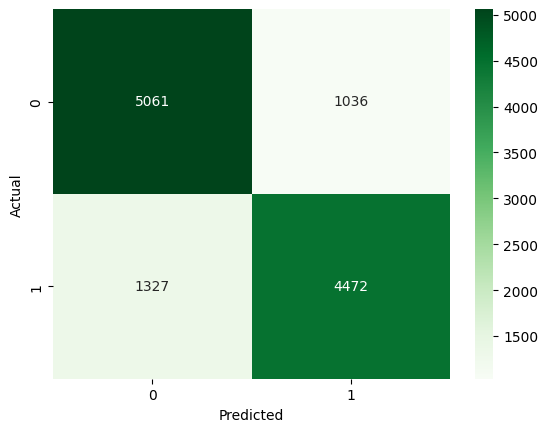

In [ ]:
knn = train_with_cv(KNeighborsClassifier(n_jobs=-1), knn_best_params, folds, x_train, y_train)

#Evaluo en el set de test
y_pred_proba= knn.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=knn.predict(x_test)
show_performance(y_test, y_pred)

In [ ]:
knn_final_score = f1_score(y_test, y_pred, average='binary')

# Clasificación con SVM


### Normalizado

In [ ]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [ ]:
#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm = stand_scaler.transform(x_test)

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      6097
           1       0.83      0.69      0.76      5799

    accuracy                           0.78     11896
   macro avg       0.79      0.78      0.78     11896
weighted avg       0.79      0.78      0.78     11896



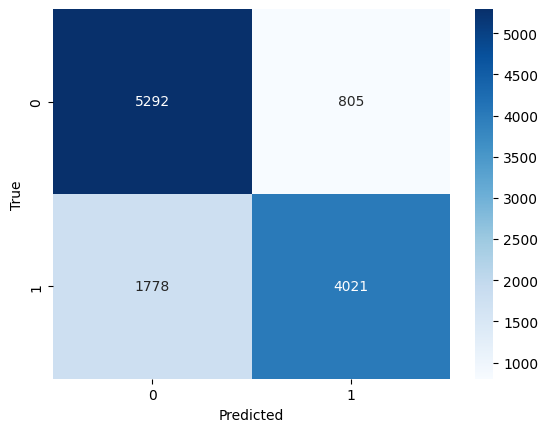

In [ ]:
#Construyo un modelo SVM  
svm_norm= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(x_test_norm)
metricas(y_pred_norm,y_test)

### PCA

Text(0, 0.5, 'Varianza Explicada (%)')

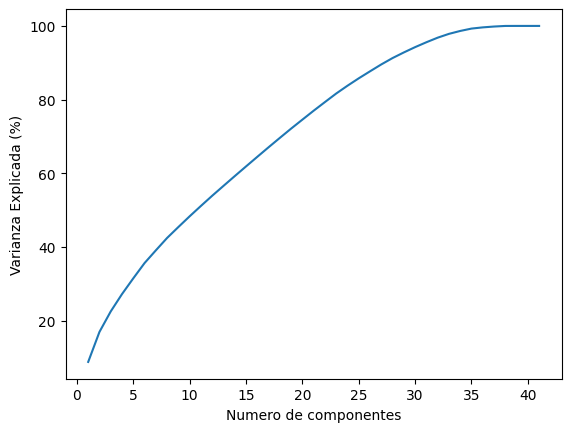

In [ ]:
#PCA sobre los datos escalados
pca = PCA(n_components = None)
pca.fit(x_train_norm)

#Cantidad de Componentes
componentes = len(pca.explained_variance_ratio_) 

#Grafico la Varianza Explicada 
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")

              precision    recall  f1-score   support

           0       0.75      0.85      0.79      6097
           1       0.82      0.69      0.75      5799

    accuracy                           0.77     11896
   macro avg       0.78      0.77      0.77     11896
weighted avg       0.78      0.77      0.77     11896



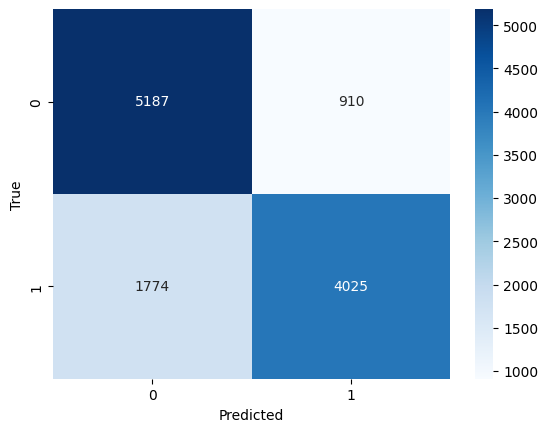

In [ ]:
_pca = PCA(n_components = 15)
_model = SVC()

#Creo un pipeline
svm_model = Pipeline([
    ('pca', _pca),
    ('svm', _model)
])

#Entreno sobre los datos que serán previamente escalados y transformados
svm_model.fit(x_train_norm,y_train)

#Hago la predicción y calculo las métricas
y_pred_pca=svm_model.predict(x_test_norm)
metricas(y_pred_pca,y_test)

###Optimización de hiperparámetros

In [ ]:
#Tomo un subconjunto de los datos de entrenamiento para que no tarde tanto

x_train_small, _, y_train_small, _ = train_test_split(x_train, y_train, train_size=0.3)
x_train_small_norm = stand_scaler.fit_transform(x_train_small)

####Kernel linear

In [ ]:
#Uso GridSearchCV para optimizar los hiperparámetros para el kernel linear

from sklearn.model_selection import GridSearchCV
  
param_grid = {'svm__C': [0.1, 1, 10], 
              'svm__kernel': ['linear']} 

if not inject:
  grid_lin = GridSearchCV(svm_model, param_grid, cv=7, verbose=3, n_jobs=7)

  start = time.time()

  grid_lin.fit(x_train_small_norm, y_train_small)
  y_pred_lin = grid_lin.predict(x_test_norm)

  print(f"Best score: {grid_lin.best_score_}, found in {time.time() - start}")
  print(grid_lin.best_params_)
  metricas(y_pred_lin,y_test)

####Kernel radial

In [ ]:
#Uso GridSearchCV para optimizar los hiperparámetros para el kernel radial

from sklearn.model_selection import GridSearchCV
  
param_grid = {'svm__C': [0.1, 1, 10], 
              'svm__gamma': [1, 0.1, 0.01],
              'svm__kernel': ['rbf']} 

if not inject:
  grid_rad = GridSearchCV(svm_model, param_grid, cv=7, verbose=3, n_jobs=7)

  start = time.time()

  grid_rad.fit(x_train_small_norm, y_train_small)
  y_pred_rad = grid_rad.predict(x_test_norm)

  print(f"Best score: {grid_rad.best_score_}, found in {time.time() - start}")
  print(grid_rad.best_params_)
  metricas(y_pred_rad,y_test)

####Kernel polinómico

In [ ]:
#Uso GridSearchCV para optimizar los hiperparámetros para el kernel polinómico

from sklearn.model_selection import GridSearchCV
  
param_grid = {'svm__C': [1, 10, 100], 
              'svm__gamma': [0.1, 0.01],
              'svm__degree': [3],
              'svm__coef0': [0, 0.5, 1],
              'svm__kernel': ['poly']} 

if not inject:
    grid_poly = GridSearchCV(svm_model, param_grid, cv=7, verbose=3, n_jobs=7)
    start = time.time()
    grid_poly.fit(x_train_small_norm, y_train_small)

    y_pred_poly = grid_poly.predict(x_test_norm)

    print(f"Best score: {grid_poly.best_score_}, found in {time.time() - start}")
    print(grid_poly.best_params_)
    metricas(y_pred_poly,y_test)


###Kernels

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      6097
           1       0.79      0.70      0.74      5799

    accuracy                           0.76     11896
   macro avg       0.76      0.76      0.76     11896
weighted avg       0.76      0.76      0.76     11896



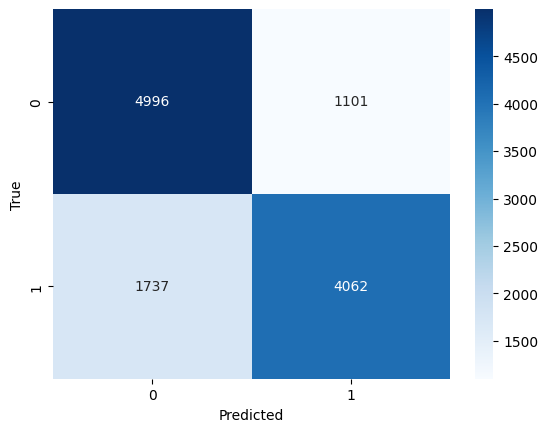

In [ ]:
#Clasificador con kernel lineal
clf_lin = SVC(kernel='linear', C=0.1)
clf_lin.fit(x_train_norm, y_train)

#Predicción y métricas
y_pred_lin = clf_lin.predict(x_test_norm)
metricas(y_pred_lin,y_test)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      6097
           1       0.81      0.77      0.79      5799

    accuracy                           0.80     11896
   macro avg       0.80      0.80      0.80     11896
weighted avg       0.80      0.80      0.80     11896



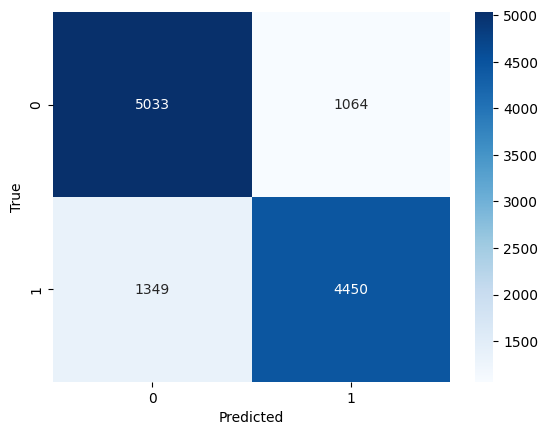

In [ ]:
#Clasificador con kernel radial
clf_rad = SVC(kernel='rbf', C=10, gamma=0.1)
clf_rad.fit(x_train_norm, y_train)

#Predicción y métricas
y_pred_rad=clf_rad.predict(x_test_norm)
metricas(y_pred_rad,y_test)

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      6097
           1       0.81      0.74      0.77      5799

    accuracy                           0.79     11896
   macro avg       0.79      0.79      0.79     11896
weighted avg       0.79      0.79      0.79     11896



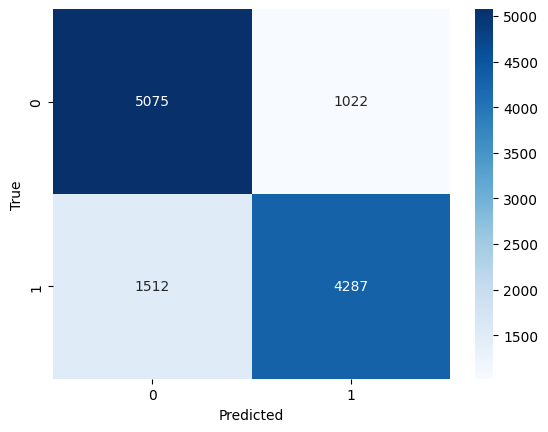

In [ ]:
#Clasificador con kernel polinómico (f)
clf_poly = SVC(kernel='poly', C=1, degree=3, coef0=1, gamma=0.1)
clf_poly.fit(x_train_norm, y_train)

#Predicción y métricas
y_pred_poly=clf_poly.predict(x_test_norm)
metricas(y_pred_poly,y_test)

In [ ]:
#Selecciono el kernel con el mejor resultado:
score_lin = f1_score(y_test, y_pred_lin)
score_rad = f1_score(y_test, y_pred_rad)
score_poly = f1_score(y_test, y_pred_poly)

if not inject: 
  results = [(clf_lin, score_lin, grid_lin.best_params_),(clf_rad, score_rad, grid_rad.best_params_),(clf_poly, score_poly, grid_poly.best_params_)]
  best_kernel, best_score, svm_best_params = max(results, key=lambda x: x[1])
  print(f"El kernel con el score más alto fue: {best_kernel}, con un score de {best_score} y usando los siguientes parámetros: {svm_best_params}")

In [ ]:
svm_best_params = svm_best_params if not inject else {'kernel':'rbf', 'C':10, 'gamma':0.1}

In [ ]:
svm_final_score = score_rad

# Clasificación con XGBoost


In [ ]:
#Optimizamos Hiperparametros.

xgb_pipeline = Pipeline([('classifier',XGBClassifier(random_state=50))])

gbm_param_grid = {
    'classifier__n_estimators': np.array([100,200,300]),        
    'classifier__subsample': np.array([0.7,0.8,0.9]),    
    'classifier__max_depth': np.array([10,11,12,13]), 
    'classifier__lambda': np.array([0.1, 0.5, 0.9, 1]),
    'classifier__gamma': np.array([0, 1 , 10]),
    'classifier__alpha': np.array([0, 10, 25 ,50, 100])
}

iters = 75
folds = 7
scorer = make_scorer(sk.metrics.f1_score)

search = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=gbm_param_grid, n_jobs= -1, n_iter=iters,scoring=scorer, verbose=3, cv=folds) 
start = time.time()
if not inject:
  search.fit(X = x_train, y = y_train)
  print_search(search, start)

In [ ]:
#Best Score: 0.82
xgboost_best_params = search.best_params_ if not inject else {'classifier__subsample': 0.9, 
      'classifier__n_estimators': 300, 
      'classifier__max_depth': 12, 
      'classifier__lambda': 1.0, 
      'classifier__gamma': 1, 
      'classifier__alpha': 0
}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:   38.5s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:   38.5s remaining:   51.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   38.6s remaining:   28.9s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:   38.6s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   38.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   38.8s finished


Best Score: 0.8233886645730522
AUC: 0.9053938394303306
F1 Score: 0.8143962444579675
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.83      0.83      6097
           1       0.82      0.81      0.81      5799

    accuracy                           0.82     11896
   macro avg       0.82      0.82      0.82     11896
weighted avg       0.82      0.82      0.82     11896



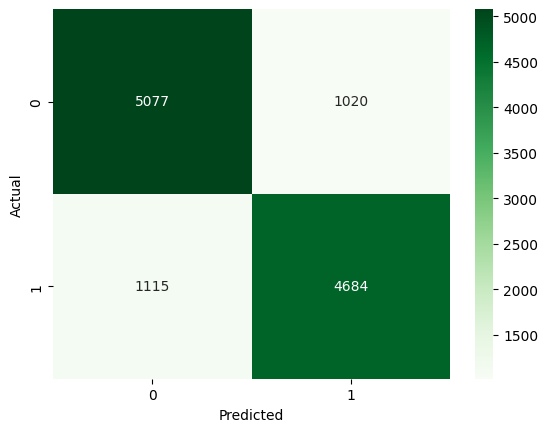

In [ ]:
xgboost = train_with_cv(Pipeline([('classifier',XGBClassifier(random_state=50))]), xgboost_best_params, folds, x_train, y_train)

#Evaluo en el set de test
y_pred_proba= xgboost.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=xgboost.predict(x_test)
show_performance(y_test, y_pred)

In [ ]:
xgb_final_score = f1_score(y_test, y_pred, average='binary')

#Ensambles

## Random Forest

In [ ]:
model = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

import time

param_grid = { "criterion" : ["gini", "entropy"], 
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
 }

#Probamos entrenando sólo con 1 métrica
scorer = make_scorer(sk.metrics.f1_score)

iters = 75
folds = 7

start = time.time()
search = RandomizedSearchCV(model, param_grid, scoring=scorer, cv=folds, n_jobs=1, n_iter=iters, verbose = 10, random_state=231)
if not inject:
  search.fit(X = x_train, y = y_train)
  print_search(search, start)

In [ ]:
#Mejor Result: 0.82
rforest_best_params = search.best_params_ if not inject else {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'entropy'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1997s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 268 ta

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

[CV] END ......................................., score=0.830 total time=  28.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0675s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1914s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

[CV] END ......................................., score=0.834 total time=  27.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0734s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1833s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    2.4s
[Parallel(n_j

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

[CV] END ......................................., score=0.825 total time=  28.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0681s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1941s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

[CV] END ......................................., score=0.830 total time=  31.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0801s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 328 ta

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

[CV] END ......................................., score=0.829 total time=  34.3s
Best Score: 0.8338186131780438


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 197 tasks      | elaps

AUC: 0.913838127599893


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 218 tasks      | elapsed:    0.2s
[Paralle

F1 Score: 0.8242626404494382
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.85      0.84      6097
           1       0.84      0.81      0.82      5799

    accuracy                           0.83     11896
   macro avg       0.83      0.83      0.83     11896
weighted avg       0.83      0.83      0.83     11896



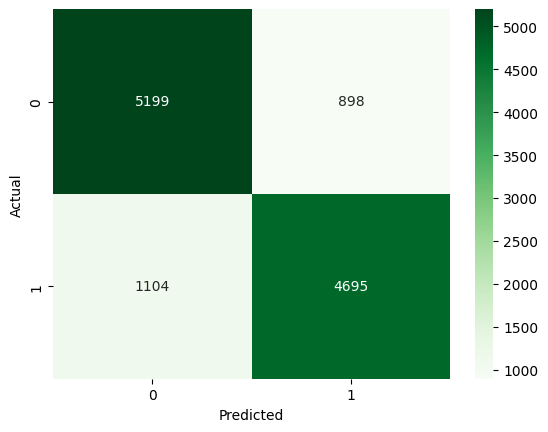

In [ ]:
new_rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, verbose = 10, n_jobs = -1)
rforest = train_with_cv(new_rf, rforest_best_params, 5, x_train, y_train,1)

#Evaluo en el set de test
y_pred_proba= rforest.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=rforest.predict(x_test)
show_performance(y_test, y_pred)

In [ ]:
rf_final_score = f1_score(y_test, y_pred, average='binary')

## Stacking

In [ ]:
#Modelos Base
base_models = [('random_forest', RandomForestClassifier(max_features='auto', oob_score=True, random_state=1).set_params(**rforest_best_params)),
               ('xgboost', Pipeline([('classifier',XGBClassifier(random_state=50))]).set_params(**xgboost_best_params)),
               ('knn', KNeighborsClassifier().set_params(**knn_best_params))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=False,
                                    cv=3,
                                    verbose=10,
                                    )

In [ ]:
#Performance el modelo en entrenamiento
stacking_model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3

StackingClassifier(cv=3,
                   estimators=[('random_forest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=60,
                                                       n_estimators=1800,
                                                       oob_score=True,
                                                       random_state=1)),
                               ('xgboost',
                                Pipeline(steps=[('classifier',
                                                 XGBClassifier(alpha=0,
                                                               base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               early_stopping_ro...
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=12,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=300,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...))])),
                               ('knn',
                                KNeighborsClassifier(algorithm='brute',
                                                     leaf_size=120,
                                                     metric='manhattan',
                                                     n_neighbors=120,
                                                     weights='distance'))],
                   final_estimator=LogisticRegressionCV(), verbose=10)

F1 Score: 0.8297853701270258
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      6097
           1       0.84      0.82      0.83      5799

    accuracy                           0.84     11896
   macro avg       0.84      0.84      0.84     11896
weighted avg       0.84      0.84      0.84     11896



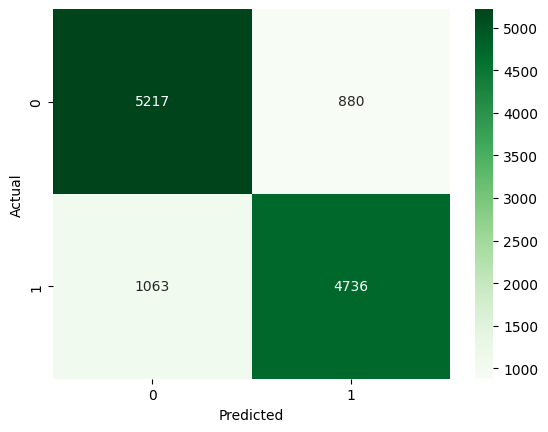

In [ ]:
#Matriz de Confusion
y_pred=stacking_model.predict(x_test)
show_performance(y_test, y_pred)

In [ ]:
stack_final_score = f1_score(y_test, y_pred, average='binary')

## Voting

In [ ]:
#Creo clasificadores

#Utilizar los mejores parametros que se encu
rnd_clf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1).set_params(**rforest_best_params)
knn_clf = KNeighborsClassifier().set_params(**knn_best_params)
xgb_clf = Pipeline([('classifier',XGBClassifier(random_state=50))]).set_params(**xgboost_best_params)


#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('rnd', rnd_clf), ('knn', knn_clf), ('xgb', xgb_clf)], n_jobs=-1)

In [ ]:
#Optimizo el ensamble
params = {'voting':['hard', 'soft'],
          'weights':[(1,1,1), (2,1,1), 
                     (1,2,1), (1,1,2),
                     (2,2,1),(1,2,2),
                     (2,1,2)]}

folds = 3
iters = 7
#Probamos entrenando sólo con 1 métrica
scorer = make_scorer(sk.metrics.f1_score)

start = time.time()
search = RandomizedSearchCV(estimator=vot_clf, param_distributions = params, scoring=scorer, cv=folds, n_iter=iters,n_jobs=3, verbose = 10)
if not inject:
  search.fit(x_train, y_train)
  print_search(search, int(start))

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Mean scores: [0.81769567 0.82449092 0.82551633 0.823909   0.80366193 0.82457299
 0.82284719] found in 580.0861790180206
{'weights': (2, 1, 1), 'voting': 'soft'}
0.8255163314084503


In [ ]:
print_search(search,start)

Mean scores: [0.81769567 0.82449092 0.82551633 0.823909   0.80366193 0.82457299
 0.82284719] found in 593.0665402412415
{'weights': (2, 1, 1), 'voting': 'soft'}
0.8255163314084503


In [ ]:
#Mejor Result: 
vot_clf_best_params = search.best_params_ if not inject else {'weights': (2, 1, 1), 'voting': 'soft'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ......................................., score=0.827 total time=  21.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.6s remaining:    0.0s


[CV] END ......................................., score=0.822 total time=  22.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.7s remaining:    0.0s


[CV] END ......................................., score=0.827 total time=  24.6s
Best Score: 0.8272442588726513


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


AUC: 0.9100142624399251
F1 Score: 0.8221399612198133
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      6097
           1       0.84      0.80      0.82      5799

    accuracy                           0.83     11896
   macro avg       0.83      0.83      0.83     11896
weighted avg       0.83      0.83      0.83     11896



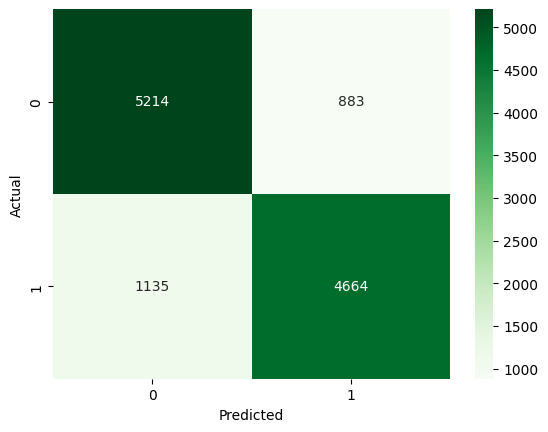

In [ ]:
new_vot_clf = VotingClassifier(estimators = [('rnd', rnd_clf), ('knn', knn_clf), ('xgb', xgb_clf)], n_jobs=1)
vot_clf = train_with_cv(new_vot_clf, vot_clf_best_params, 3, x_train, y_train, 1)

#Evaluo en el set de test
y_pred_proba= vot_clf.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=vot_clf.predict(x_test)
show_performance(y_test, y_pred)

In [ ]:
voting_final_score = f1_score(y_test, y_pred, average='binary')

## Eleccion de Modelo
> Elegimos el modelo para correr con kaggle.

In [ ]:
#Modulo para elegir que modelo correr.
model = vot_clf
best_params = model.get_params()
final_score = voting_final_score

# Kaggle

In [ ]:
# Nos traemos el dataset de test sin el ID.
x_sub = df_hotels_test_encoded.select_dtypes(exclude=['object'])

# Predecimos con nuestro mejor modelo
y_sub = model.predict(x_sub)
y_sub

# Armamos un DF
df_sub = pd.DataFrame({'id': df_hotels_test['id'], 'is_canceled': y_sub})
df_sub

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,0


In [ ]:
# Nos guardamos el modelo y el resultado.
import os.path
import time
import json

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

timestr = time.strftime("%Y%m%d-%H%M%S")
os.mkdir(f'submissions/{timestr}')
df_sub.to_csv(f'submissions/{timestr}/{final_score}.csv', index=False)

#Persisitimos los parametros usados.
with open(f'submissions/{timestr}/params-{final_score}.txt', 'w') as params_file:
     params_file.write(json.dumps(best_params, default=np_encoder))

# Persistimos el modelo asociado.
model_filename = f'submissions/{timestr}/modelo.pickle'
pickle.dump(model, open(model_filename, "wb"))